# Sea surface vertical velocity along a cross-section

How to install module:


- https://pypi.org/project/seissolxdmf/
- !pip install seissolxdmf

In [36]:
# download from https://pypi.org/project/seissolxdmf/
import seissolxdmf 

import pyproj

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib

import numpy as np

from cmcrameri import cm

from mpl_toolkits.basemap import Basemap, maskoceans
from netCDF4 import Dataset

import pandas as pd

In [37]:
plt.rcParams["font.family"] = "sans-serif"
ps = 20
plt.rcParams.update({"font.size": ps})
plt.rcParams["font.family"] = "sans"
matplotlib.rc("xtick", labelsize=ps)
matplotlib.rc("ytick", labelsize=ps)

In [38]:
transformer = pyproj.Transformer.from_crs("utm27", "epsg:4326", always_xy=True)
#transformer = pyproj.Transformer.from_crs("epsg:32627", "epsg:4326", always_xy=True)

In [39]:
def plot_ssha(xdmfFilename,timestep):
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    m = Basemap(epsg=4326, resolution="c", llcrnrlon=x1, urcrnrlon=x2, llcrnrlat=y1, urcrnrlat=y2)#4326
    bathy = "/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/GEBCO_08_Dec_2021_074bdff0ecf9/gebco_2021_n68.0_s62.0_w-25.0_e-12.0.nc"
    fh = Dataset(bathy, mode="r")
    y = fh.variables["lat"][:]
    x = fh.variables["lon"][:]
    z = fh.variables["elevation"][:, :]
    fh.close()
    idx = np.where((x > x1) & (x < x2))[0]
    idy = np.where((y > y1) & (y < y2))[0]
    x = x[idx]
    y = y[idy]
    z = z[idy, :]
    z = z[:, idx]
    lon, lat = np.meshgrid(x, y)
    X, Y = m(lon, lat)
    # Coast line
    plt.contour(X, Y, z, levels=[0], colors="k")

    sx = seissolxdmf.seissolxdmf(xdmfFilename) # initiate class
    dt = sx.ReadTimeStep()
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("u3", timestep)    
    XYZcenters0 = (xyz[connect[:, 0], :] + xyz[connect[:, 1], :] + xyz[connect[:, 2], :]) / 3.0
    Zcenters0 = abs(XYZcenters0[:, 2])
    U = U[Zcenters0 < 0.001]
    connect = connect[Zcenters0 < 0.001]
    
    lon, lat = transformer.transform(xyz[:,0], xyz[:,1])
    x, y = m(lon,lat)
    plt.tripcolor(x, y, connect, facecolors=U, cmap=cm.cork, rasterized=True)
    plt.xlim(x1,x2)
    plt.xticks(np.arange(x1,x2, step=0.5))
    plt.title("t = {} s".format(timestep*dt))
    plt.ylim(y1,y2)
    plt.clim(-0.6, 0.6)
    
    plt.text(-17.0, 66.15, "sea surface height anomaly (m)", va="center", fontsize=ps, rotation="vertical")
    # loc=4 means lower right
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax1, width=0.15, height="60%", loc=4)
    cbar = plt.colorbar(cax=cbaxes, ticks=[-0.6,-0.3,0.0,0.3,0.6])
    cbar.ax.tick_params(which="major", labelsize=ps, length=10, width=2, direction="inout")
    cbar.ax.tick_params(which="minor", length=6, width=1.0)

In [40]:
def plot_ssvv(ax,xdmfFilename,timestep,barcolor):
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    m = Basemap(epsg=4326, ax=ax, resolution="c", llcrnrlon=x1, urcrnrlon=x2, llcrnrlat=y1, urcrnrlat=y2)
    bathy = "/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/GEBCO_08_Dec_2021_074bdff0ecf9/gebco_2021_n68.0_s62.0_w-25.0_e-12.0.nc"
    fh = Dataset(bathy, mode="r")
    y = fh.variables["lat"][:]
    x = fh.variables["lon"][:]
    z = fh.variables["elevation"][:, :]
    fh.close()
    idx = np.where((x > x1) & (x < x2))[0]
    idy = np.where((y > y1) & (y < y2))[0]
    x = x[idx]
    y = y[idy]
    z = z[idy, :]
    z = z[:, idx]
    lon, lat = np.meshgrid(x, y)
    X, Y = m(lon, lat)
    # Coast line
    ax.contour(X, Y, z, levels=[0], colors="k")

    sx = seissolxdmf.seissolxdmf(xdmfFilename) # initiate class
    dt = sx.ReadTimeStep()
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("v3", timestep)    
    XYZcenters0 = (xyz[connect[:, 0], :] + xyz[connect[:, 1], :] + xyz[connect[:, 2], :]) / 3.0
    Zcenters0 = abs(XYZcenters0[:, 2])
    U = U[Zcenters0 < 0.001]
    connect = connect[Zcenters0 < 0.001]
    
    lon, lat = transformer.transform(xyz[:,0], xyz[:,1])
    x, y = m(lon,lat)
    
    im = ax.tripcolor(x, y, connect, facecolors=U, cmap=cm.cork, rasterized=True, vmin=-0.6, vmax=0.6)
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    ax.set_xlim(x1,x2)
    ax.set_xticks(np.arange(x1,x2, step=0.5))
    ax.set_title("t = {} s".format(timestep*dt))
    ax.set_ylim(y1,y2)
    #plt.clim(-0.3, 0.3)
    
    
    if barcolor==True:
        plt.text(-17.0, 66.15, "sea surface vertical velocity (m/s)", va="center", fontsize=ps, rotation="vertical")
    # loc=4 means lower right
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cbaxes = inset_axes(ax, width=0.15, height="60%", loc=4)
        cbar = fig.colorbar(im, cax=cbaxes, orientation='vertical', ticks=[-0.6,-0.3,0.0,0.3,0.6])
        cbar.ax.tick_params(which="major", labelsize=ps, length=10, width=2, direction="inout")
        cbar.ax.tick_params(which="minor", length=6, width=1.0)
        #cbar.ax.minorticks_on()

In [41]:
xdmfFilename = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_II/HFFZ_full-surface.xdmf"

# Write receiver line

In [42]:
#check within paraview
x_0 = 612800
x_1 = 635000
y_0 = 7327000
y_1 = 7365000

lon_0, lat_0 = transformer.transform(x_0, y_0)
lon_1, lat_1 = transformer.transform(x_1, y_1)

In [43]:
(x_1-x_0)/1000

22.2

In [44]:
num = 1001
x_range = np.linspace(x_0,x_1,num)
y_range = np.linspace(y_0,y_1,num)
z_range = np.zeros(num) - 0.1
receiver_line = pd.DataFrame(np.column_stack([x_range, y_range, z_range]))
#receiver_line.to_csv("receiver_line.csv", index=False, header=None, sep=' ')

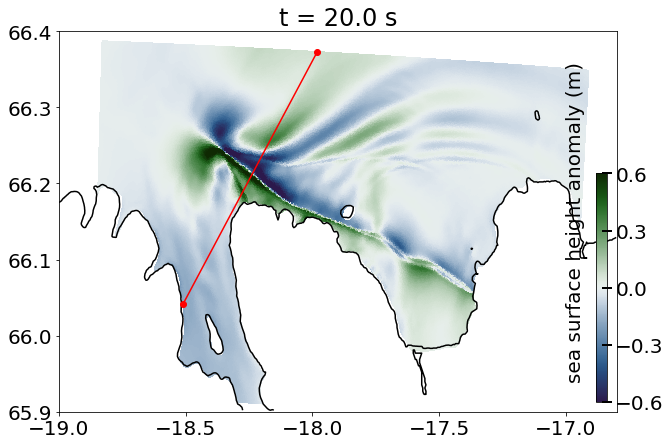

In [45]:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax1 = plt.gca()
plot_ssha(xdmfFilename,20)

#ax1.plot([x0, x1], [y0, y1], 'b--')
ax1.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')

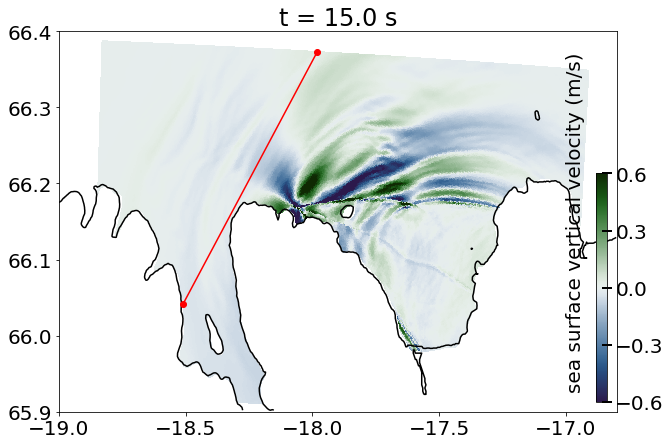

In [46]:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax1 = plt.gca()
plot_ssvv(ax1,xdmfFilename,15,True)
ax1.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')

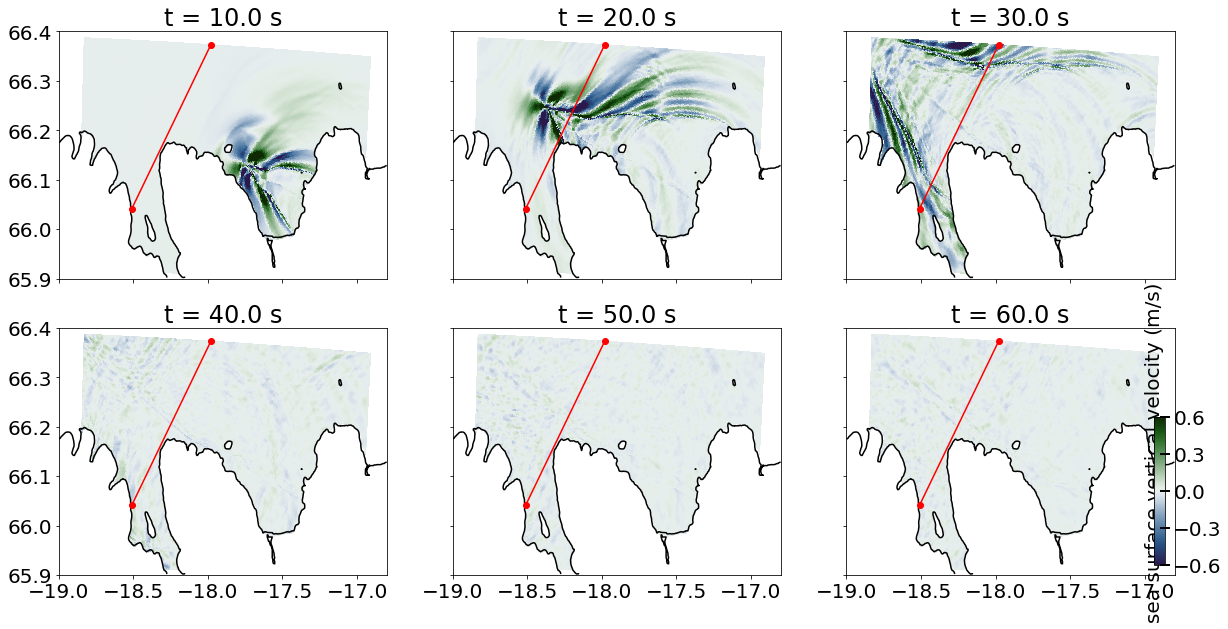

In [50]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20,10))
#fig.set_figwidth(20)

plot_ssvv(ax1,xdmfFilename,10,False)
ax1.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')
plot_ssvv(ax2,xdmfFilename,20,False)
ax2.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')
plot_ssvv(ax3,xdmfFilename,30,False)
ax3.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')
plot_ssvv(ax4,xdmfFilename,40,False)
ax4.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')
plot_ssvv(ax5,xdmfFilename,50,False)
ax5.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')
plot_ssvv(ax6,xdmfFilename,60,True)
ax6.plot([lon_0, lon_1], [lat_0, lat_1], 'ro-')

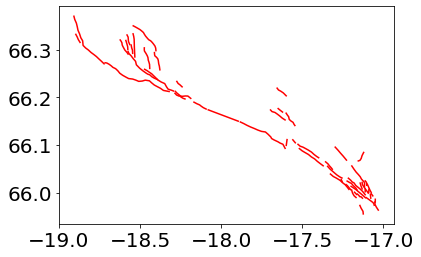

In [48]:
for i in range(1,56):
    df = pd.read_csv('/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/HFF_fault_traces_complex/fault_{}.txt'.format(i), names=['LON', 'LAT'],sep=' ')
    plt.plot(df.LON,df.LAT,color='r')

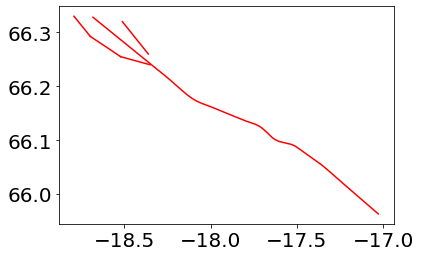

In [51]:
for i in range(6,10):
    df = pd.read_csv('/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/HFF_fault_traces_simple/fault_{}.txt'.format(i), names=['LON', 'LAT'], sep='\s+') 
    plt.plot(df.LON,df.LAT,color='r')
df = pd.read_csv("/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/HFF_fault_traces_simple_connected/fault_1_lon_lat.dat", names=['LON', 'LAT'], sep='\s+')
plt.plot(df.LON,df.LAT,color='r')